In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim

In [2]:
import os
import pandas as pd

file_path = "/home/dl09e24/DATA/TMDB_movie_dataset_v11.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load the dataset
df = pd.read_csv(file_path)

In [3]:
print(df.head())

       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

      revenue  runtime  adult                     backdrop_path  ...  \
0   825532764      148  False  /8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg  ...   
1   701729206      169  False  /pbrkL804c8yAv3zBZR4QPEafpAR.jpg  ...   
2  1004558444      152  False  /nMKdUUepR0i5zn0y1T4CsSB5chy.jpg  ...   
3  2923706026      162  False  /vL5LR6WdxWPjLPFRLe133jXWsh5.jpg  ...   
4  1518815515      143  False  /9BBTo63ANSmhC4e6r62OJFuK2GL.jpg  ...   

    original_title                                           overview  \
0        Inception 

In [4]:
features = ['title', 'vote_count', 'runtime', 'revenue', 'popularity']
target = 'vote_average'

In [5]:
df = df[features + [target]].dropna()

In [6]:
bins = [0, 5.5, 7.0, 10.0]
labels = [0, 1, 2]  # 0: BAD, 1: AVG, 2: GOOD
df['vote_category'] = pd.cut(df[target], bins=bins, labels=labels)

In [7]:
print(df['vote_category'].isnull().sum())  # Count the number of NaN values
print(df['vote_category'].unique()) 

784152
[2, 1, 0, NaN]
Categories (3, int64): [0 < 1 < 2]


In [8]:
df = df.dropna(subset=['vote_category'])

# Verify if NaN values are removed
print(f"Remaining rows: {len(df)}")
print(f"Any NaN in 'vote_category': {df['vote_category'].isna().sum()}")

Remaining rows: 350162
Any NaN in 'vote_category': 0


In [9]:
print(df['vote_category'].isnull().sum())  # Count the number of NaN values
print(df['vote_category'].unique())

0
[2, 1, 0]
Categories (3, int64): [0 < 1 < 2]


In [10]:
df['vote_category'] = df['vote_category'].astype(int)

In [11]:
X = df[features].values
y = df['vote_category'].values

print(df[features].dtypes)  # Check the data types of the features

title          object
vote_count      int64
runtime         int64
revenue         int64
popularity    float64
dtype: object


In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode titles as integers
label_encoder = LabelEncoder()
df['title_encoded'] = label_encoder.fit_transform(df['title'])

# Update the feature list
features = ['title_encoded', 'vote_count', 'runtime', 'revenue', 'popularity']

In [13]:
print(df['title_encoded'].dtype)  # Should be int64 or int32
print(df['title_encoded'].head())  # Inspect the first few rows

int64
0    118864
1    120425
2    243564
3     26236
4    237602
Name: title_encoded, dtype: int64


In [14]:
print(df[features].isnull().sum())  # Check for null values
df = df.dropna(subset=features)  # Drop rows with missing values

title_encoded    0
vote_count       0
runtime          0
revenue          0
popularity       0
dtype: int64


In [15]:
for feature in features:
    print(f"{feature}: {df[feature].dtype}")  # Confirm numeric dtype

title_encoded: int64
vote_count: int64
runtime: int64
revenue: int64
popularity: float64


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df[features].values)  # Transform features

In [17]:
from sklearn.model_selection import train_test_split

# Initial Train + Validation and Test Split (80% Train+Val, 20% Test)
train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Split Train + Validation into Train (60%) and Validation (20%) of the original dataset
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)  # 0.25 * 80% = 20%

# Verify the proportions
print(f"Train Data: {len(train_data)} rows ({len(train_data) / len(df):.2%})")
print(f"Validation Data: {len(val_data)} rows ({len(val_data) / len(df):.2%})")
print(f"Test Data: {len(test_data)} rows ({len(test_data) / len(df):.2%})")

Train Data: 210096 rows (60.00%)
Validation Data: 70033 rows (20.00%)
Test Data: 70033 rows (20.00%)


In [18]:
# Extract features and target for train, validation, and test sets
X_train = train_data[features].values
y_train = train_data['vote_category'].values

X_val = val_data[features].values
y_val = val_data['vote_category'].values

X_test = test_data[features].values
y_test = test_data['vote_category'].values

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [19]:
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        # CNN Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(128)  # Corrected to match Conv1d output channels
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(256)  # Corrected to match Conv1d output channels
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(512)  # Corrected to match Conv1d output channels
        self.dropout_cnn = nn.Dropout(0.5)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, batch_first=True, dropout=0.3)

        # Fully Connected Layer
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for Conv1D
        x = self.dropout_cnn(F.relu(self.bn1(self.conv1(x))))
        if x.size(-1) > 1:  # Check if pooling can be applied
            x = F.max_pool1d(x, kernel_size=2)

        x = self.dropout_cnn(F.relu(self.bn2(self.conv2(x))))
        if x.size(-1) > 1:  # Check if pooling can be applied
            x = F.max_pool1d(x, kernel_size=2)

        x = self.dropout_cnn(F.relu(self.bn3(self.conv3(x))))
        if x.size(-1) > 1:  # Check if pooling can be applied
            x = F.max_pool1d(x, kernel_size=2)

        x = x.transpose(1, 2)  # Prepare for LSTM: (batch, time_steps, features)
        x, (hidden, _) = self.lstm(x)  # LSTM processing
        x = hidden[-1]  # Use the last layer's hidden state
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
input_size = 512  # Adjust based on input sequence length after CNN layers
num_classes = 3   # GOOD, AVG, BAD
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_LSTM_Model(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

Epoch [1/25]
Train Loss: 3537.5219, Train Accuracy: 38.87%
Validation Loss: 1186.1982, Validation Accuracy: 37.84%
Validation accuracy improved. Model saved.
Epoch [2/25]
Train Loss: 3537.5361, Train Accuracy: 38.81%
Validation Loss: 1195.1709, Validation Accuracy: 37.84%
No improvement in validation accuracy for 1 epoch(s).
Epoch [3/25]
Train Loss: 3537.4158, Train Accuracy: 38.88%
Validation Loss: 1187.2809, Validation Accuracy: 37.84%
No improvement in validation accuracy for 2 epoch(s).
Epoch [4/25]
Train Loss: 3537.2707, Train Accuracy: 38.83%
Validation Loss: 1191.2454, Validation Accuracy: 37.84%
No improvement in validation accuracy for 3 epoch(s).
Epoch [5/25]
Train Loss: 3537.4183, Train Accuracy: 38.96%
Validation Loss: 1191.7547, Validation Accuracy: 37.84%
No improvement in validation accuracy for 4 epoch(s).
Epoch [6/25]
Train Loss: 3537.3910, Train Accuracy: 38.82%
Validation Loss: 1188.3144, Validation Accuracy: 37.84%
No improvement in validation accuracy for 5 epoch(s

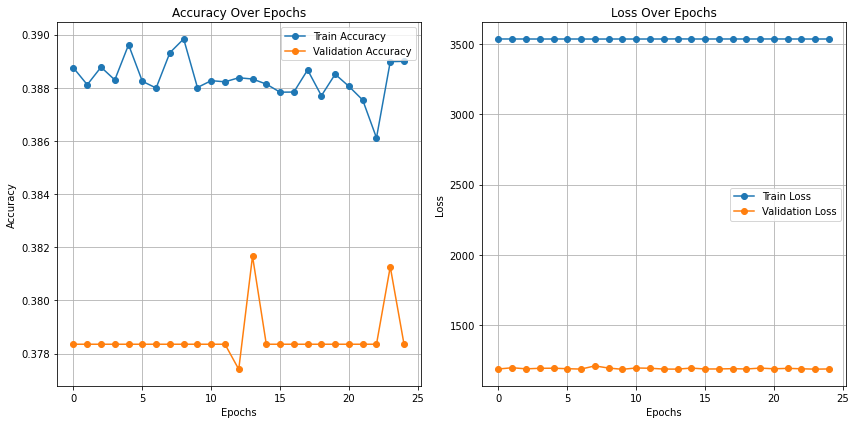

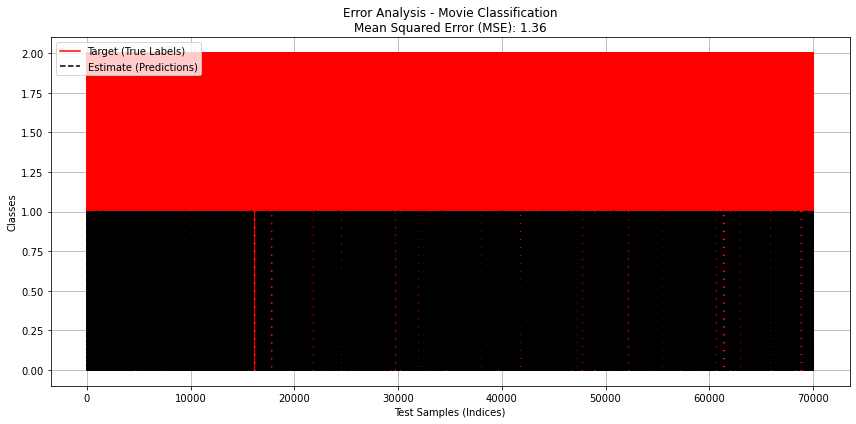

          Name         Type   Params
0        conv1       Conv1d      512
1          bn1  BatchNorm1d      256
2        conv2       Conv1d    98560
3          bn2  BatchNorm1d      512
4        conv3       Conv1d   393728
5          bn3  BatchNorm1d     1024
6  dropout_cnn      Dropout        0
7         lstm         LSTM  1314816
8          fc1       Linear    32896
9          fc2       Linear      387
Test Loss: 1185.5177, Test Accuracy: 37.91%, MSE: 1.3599


In [67]:
import time
from sklearn.metrics import mean_squared_error

# Train the model
def train_model_with_tracking(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, patience):
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    train_losses, val_losses, mse_values = [], [], []
    best_val_accuracy, patience_counter = 0.0, 0

    start_time = time.time()
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct_train = 0.0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == y_batch).sum().item()
        train_accuracy = correct_train / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss, correct_val = 0.0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item()
                correct_val += (outputs.argmax(1) == y_batch).sum().item()
        val_accuracy = correct_val / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(f"Epoch [{epoch + 1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Validation accuracy improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    return train_accuracies, val_accuracies, train_losses, val_losses, total_time

# Test the model
def test_model(model, test_loader, criterion):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    test_loss, correct_test = 0.0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            test_loss += criterion(outputs, y_batch).item()
            correct_test += (outputs.argmax(1) == y_batch).sum().item()
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
    mse = mean_squared_error(y_true, y_pred)
    return test_loss, correct_test / len(test_loader.dataset), mse, y_true, y_pred

# Plotting function
def plot_metrics(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Model parameters table
def show_parameters(model):
    params = [(name, module.__class__.__name__, sum(p.numel() for p in module.parameters() if p.requires_grad))
              for name, module in model.named_children()]
    df = pd.DataFrame(params, columns=["Name", "Type", "Params"])
    print(df)

# Run training, testing, and plotting
epochs = 25
patience = 15

train_acc, val_acc, train_loss, val_loss, train_time = train_model_with_tracking(
    model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, patience)

test_loss, test_acc, mse, y_true, y_pred = test_model(model, test_loader, criterion)
plot_metrics(train_acc, val_acc, train_loss, val_loss)
plot_error_analysis(y_true, y_pred, mse)
show_parameters(model)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2%}, MSE: {mse:.4f}")

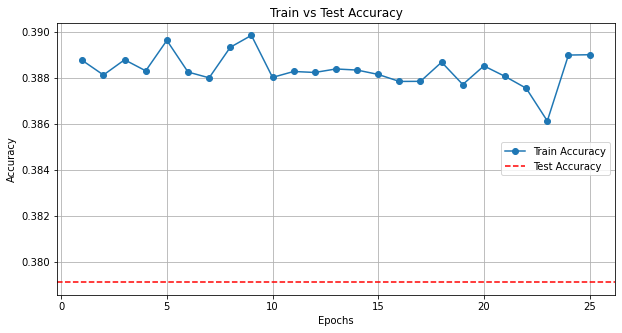

In [68]:
import matplotlib.pyplot as plt

def plot_train_test_accuracy(train_acc, test_acc, epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy", marker='o')
    plt.axhline(y=test_acc, color='r', linestyle='--', label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Usage after training and testing
plot_train_test_accuracy(train_acc, test_acc, len(train_acc))

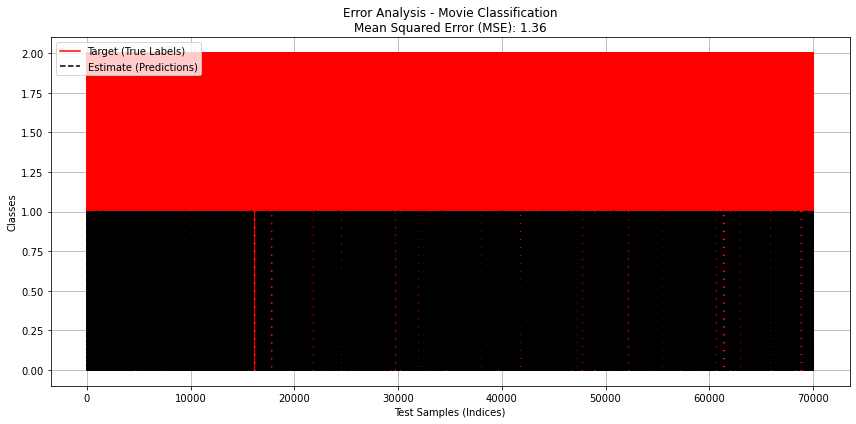

In [69]:
# Error Analysis Plot
def plot_error_analysis(y_true, y_pred, mse):
    """
    Plots the error analysis graph comparing true labels and predicted labels.

    Args:
        y_true (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        mse (float): Mean Squared Error between true and predicted labels.
    """
    time_samples = np.arange(len(y_true))  # Use indices as time samples
    plt.figure(figsize=(12, 6))

    # Plot True Labels (Target) and Predicted Labels (Estimate)
    plt.plot(time_samples, y_true, label="Target (True Labels)", color="red", linestyle="-", linewidth=1.5)
    plt.plot(time_samples, y_pred, label="Estimate (Predictions)", color="black", linestyle="--", linewidth=1.5)

    # Add MSE annotation and labels
    plt.title(f"Error Analysis - Movie Classification\nMean Squared Error (MSE): {mse:.2f}")
    plt.xlabel("Test Samples (Indices)")
    plt.ylabel("Classes")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.show()

# Call Error Analysis Function
plot_error_analysis(y_true, y_pred, mse)

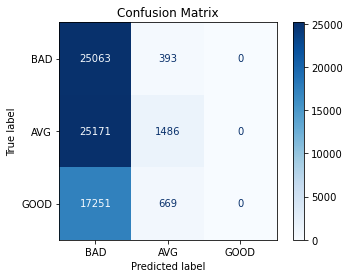

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BAD", "AVG", "GOOD"])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()